# **Projeto Guiado: Previsões Sobre o Mercado de Ações** 📈

Este projeto possui como principal objetivo a avaliação de dados referentes ao índice *Standard and Poor's 500* (S&P500), um popular indexador internacional no mercado de ações. 

O S&P500 reúne os preços de ações das 500 maiores empresas do mundo presentes nas principais bolsas de valores dos Estados Unidos: NYSE e Nasdaq. Como um indexador, este parâmetro pode ser consultado para se obter informações sobre o desempenho do mercado de ações nos EUA e sobre as reações dos investidores diante de mudanças na economia, nos negócios ou até mesmo no cenário da política internacional. 

A partir dos dados sobre o S&P500 é possível avaliar se um investimento na bolsa tem acompanhado este índice ou até mesmo superado o seu valor, se consolidando como um ativo de alta qualidade. Alguns compradores optam por investir em [fundos de investimento](https://www.infomoney.com.br/guias/etf-exchange-traded-fund/) (*Exchange Traded Funds* ou ETFs) que podem estar atrelados a um índice de referência como o S&P500.

Este índice foi criado na década de 1920, sendo composto inicialmente por 90 ações, chegando a agregar 500 empresas somente em 1957.

Maiores informações sobre a história e sobre os critérios para que uma empresa esteja listada no índice S&P500 podem ser encontrados [aqui](https://conteudos.xpi.com.br/aprenda-a-investir/relatorios/o-que-e-sp-500-saiba-a-importancia-do-indice-mais-famoso-do-mundo/).

A construção de modelos de previsão ligados a índices do mercado financeiro auxilia justamente no entendimento sobre a performance do mercado como um todo diante de cenários futuros, com base em dados do passado.

--------------------------------------------------------------------------------

<font color='red'>**Nota:**</font> O modelo desenvolvido neste projeto não deve ser utilizado para a negociação de ações ligadas ao índice S&P500. Este projeto não possui como objetivo servir como um aconselhador acerca do mercado de ações.







## **Importação de Bibliotecas** 🧰

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import datetime as dt

## **Importação do Arquivo** 📂

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving sphist.csv to sphist.csv


In [3]:
import io 
df = pd.read_csv(io.BytesIO(data_to_load['sphist.csv']))

## **Dicionário de Dados** 📘

- `Date` - Data de registro;
- `Open` - Preço do índice no início do dia (quando as negociações se iniciam);
- `High` - O maior preço registrado para o índice no dia;
- `Low` -  O menor preço registrado para o índice no dia;
- `Close` - Preço do índice no final do dia (quando as negociações se encerram);
- `Volume` - O número de ações negociadas ao longo do dia;
- `Adj Close` - Preço diário de fechamento, ajustado retroativamente para comportar qualquer ação corporativa. 

## **Leitura Inicial dos Dados** 🔍

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


In [5]:
df.shape

(16590, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


Temos ao todo 16590 linhas presentes no arquivo, não havendo nenhum dado nulo para nenhuma das colunas.



#### **Explorando melhor a coluna Date**

A coluna `Date` se encontra no formato object, mas fim de facilitar sua manipulação, será convertida para o formato datetime.

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format = "%Y-%m-%d")

In [8]:
df['Date'].dtype

dtype('<M8[ns]')

In [9]:
print(df['Date'].min())
print(df['Date'].max())

1950-01-03 00:00:00
2015-12-07 00:00:00


Os registros disponíveis vão de 1950 a 2015. Com base nesta informação, os dados serão colocados em ordem crescente de tempo.

In [10]:
df.sort_values('Date', ascending = True, inplace = True)

In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


## **Gerando Indicadores** 🔢

Por se tratar de um trabalho com dados sequenciais, torna-se interessante a criação de indicadores que levem em consideração algum tipo de histórico e aumentem a precisão do modelo que será desenvolvido.

Uma das formas de se colocar esta estratégia em prática é criando colunas que registrem:
- A média do preço do índice nos últimos 30 dias;
- A média do preço do índice nos últimos 365 dias;
- A razão entre a média do preço pelos últimos 30 dias e a média do preço pelos últimos 365 dias.

Tendo em vista que os registros do conjunto de dados se iniciam em 1950-01-03, a criação de novos indicadores será feita a partir de 1951-01-03 e levando em consideração apenas os preços de fechamento.

In [12]:
def indices(df, date, limit):

  '''
  - Função que calcula a média para os últimos 30 ou 365 dias;
  - df: dataframe com base no qual o cálculo deve ser feito;
  - date: data limite a partir da qual os valores de média serão gerados;
  - limit: número de dias retroativos sobre o qual se deseja obter o valor da média.
  '''

  view = df.loc[df['Date'] < date, 'Close']
  mean_limit = view.iloc[-(limit):].mean()
  
  return mean_limit

In [13]:
# Criação da coluna para média de valores dos últimos 30 dias:
df.loc[df['Date'] >= '1951-01-03', 'Day_30'] = df.loc[df['Date'] >= '1951-01-03', 'Date'].apply(lambda x: indices(df, x, 30))

In [14]:
# # Criação da coluna para média de valores dos últimos 365 dias:
df.loc[df['Date'] >= '1951-01-03', 'Day_365'] = df.loc[df['Date'] >= '1951-01-03', 'Date'].apply(lambda x: indices(df, x, 365))

In [15]:
# Criação da coluna que contém a razão entre a média nos últimos 30 dias em relação aos últimos 365 dias:
df['Ratio_30_365'] = df['Day_30']/df['Day_365']

In [16]:
# Visualização dos valores calculados:
df.loc[df['Date'] > '1950-12-28'].head(6)

,Date,Open,High,Low,Close,Volume,Adj Close,Day_30,Day_365,Ratio_30_365
16341,1950-12-29,20.430000,20.430000,20.430000,20.430000,3440000.0,20.430000,NaN,NaN,NaN
16340,1951-01-02,20.770000,20.770000,20.770000,20.770000,3030000.0,20.770000,NaN,NaN,NaN
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,19.815000,18.406760,1.076507
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,19.842666,18.415857,1.077477
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,19.874000,18.425595,1.078608
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,19.907000,18.435257,1.079833


Tendo em vista que os dados anteriores a 1951-01-03 não possuem informação prévia o suficiente para a geração de indicadores, eles serão descartados:

In [17]:
df.dropna(axis = 0, inplace = True)

In [18]:
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Day_30,Day_365,Ratio_30_365
16339,1951-01-03,20.690001,20.690001,20.690001,20.690001,3370000.0,20.690001,19.815000,18.406760,1.076507
16338,1951-01-04,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,19.842666,18.415857,1.077477
16337,1951-01-05,20.870001,20.870001,20.870001,20.870001,3390000.0,20.870001,19.874000,18.425595,1.078608
16336,1951-01-08,21.000000,21.000000,21.000000,21.000000,2780000.0,21.000000,19.907000,18.435257,1.079833
16335,1951-01-09,21.120001,21.120001,21.120001,21.120001,3800000.0,21.120001,19.935000,18.445354,1.080760


## **Gerando os Conjuntos de Treino e Teste** ✂️

Para este projeto, o conjunto de treino para o modelo será composto por dados que se concentram entre 1951 e 2013. Já o conjunto de teste, levará em conta dados que vão de 2013 em diante.

In [19]:
train = df.loc[df['Date'] < '2013', :]
test = df.loc[df['Date'] >= '2013', :]

In [20]:
print(train['Date'].min(), train['Date'].max())
print(test['Date'].min(), test['Date'].max())

1951-01-03 00:00:00 2012-12-31 00:00:00
2013-01-02 00:00:00 2015-12-07 00:00:00


## **Gerando Modelos Lineares para a Previsão de Preços** 🔮

Utilizando-se inicialmente um algoritmo de **regressão linear**, serão propostos diferentes modelos para previsão dos preços do índice S&P500 entre os anos de 2013 e 2015.

Os modelos serão avaliados e comparados entre si, levando em consideração as seguintes métricas de erro:
- *MSE (mean-squared-error)* - para verificar a variação dos dados previstos em relação aos dados reais e comparar o desempenho de diferentes configurações de modelo linear;
- *R-Squared (coefficient of determination)* - para avaliar a variação dos dados reais em relação ao modelo de forma percentual, levando em consideração a variação explicada diante da variação total.

### **1º Modelo: Utilizando-se apenas os indicadores como features**

In [21]:
model_1 = LinearRegression()
model_1.fit(train[['Day_30','Day_365','Ratio_30_365']], train['Close'])
predictions = model_1.predict(test[['Day_30','Day_365','Ratio_30_365']])
mse_1 = mean_squared_error(test['Close'], predictions)
r2_1 = r2_score(test['Close'], predictions)
print(f'mse_1: {mse_1}')
print(f'r2_1: {r2_1}')

mse_1: 1559.317837972119
r2_1: 0.9578146179078743


###**2º Modelo: Deixando os indicadores de fora e usando apenas o valor de abertura como feature**

Nesta configuração utilizaremos o valor do índice quando da abertura do mercado para negociações (`Open`) a fim de prever o valor de fechamento (`Close`).

In [22]:
model_2 = LinearRegression()
model_2.fit(train[['Open']], train['Close'])
predictions = model_2.predict(test[['Open']])
mse_2 = mean_squared_error(test['Close'], predictions)
r2_2 = r2_score(test['Close'], predictions)
print(f'mse_2: {mse_2}')
print(f'r2_2: {r2_2}')

mse_2: 202.92515431289127
r2_2: 0.9945101152809708


###**3º Modelo: Combinando os indicadores e o valor de abertura como features**

In [27]:
model_3 = LinearRegression()
model_3.fit(train[['Open','Day_30','Day_365','Ratio_30_365']], train['Close'])
predictions = model_3.predict(test[['Open','Day_30','Day_365','Ratio_30_365']])
mse_3 = mean_squared_error(test['Close'], predictions)
r2_3 = r2_score(test['Close'], predictions)
print(f'mse_3: {mse_3}')
print(f'r2_3: {r2_3}')

mse_3: 202.37981466636745
r2_3: 0.994524868758933


#### **Conclusões:**

Tendo em vista as diferentes configurações de modelos lineares testadas, pode-se afirmar que aquela que combinou as seguintes features, foi a que retornou resultados mais precisos para o valor do índice S&P500 quando do fechamento do mercado para negociações:
- Valor do índice quando da abertura do mercado (`Open`)
- Média dos valores do índice para os últimos 30 dias (`Day_30`)
- Média dos valores do índice para os últimos 365 dias (`Day_365`)
- Razão entre as médias dos para os últimos 30 dias e para os últimos 365 dias (`Ratio_30_365`).

Podemos utilizar esta combinação de features que trouxe melhores resultados para testarmos em um outro tipo de modelo: árvores de decisão.

### **4º modelo: Utilizando-se o algoritmo de árvore de decisão tendo como features os indicadores**

In [26]:
model_4 = DecisionTreeRegressor(max_depth = 5)
model_4.fit(train[['Open','Day_30','Day_365','Ratio_30_365']], train['Close'])
predictions = model_4.predict(test[['Open','Day_30','Day_365','Ratio_30_365']])
mse_4 = mean_squared_error(test['Close'], predictions)
print(f'mse_4: {mse_4}')

mse_4: 169976.91675445312


#### **Conclusões:**

Pelo valor de MSE, pode-se confirmar que o aumento da complexidade do modelo não resulta de forma positiva na previsão dos dados e que o uso de um modelo "mais simples" para este caso, pode ser mais vantajosa.

## **Visualizando-se de Forma Gráfica a Previsão de Preços** 📉

In [28]:
print(model_3.intercept_)
print(model_3.coef_)

0.48101629679337066
[ 0.98251712  0.01957268 -0.00208371 -0.37668686]


In [31]:
x_1 = test['Open']
x_2 = test['Day_30']
x_3 = test['Day_365']
x_4 = test['Ratio_30_365']

linear = 0.48101629679337066 + 0.98251712 * x_1 + 0.01957268 * x_2 - 0.00208371 * x_3 - 0.37668686 * x_4 

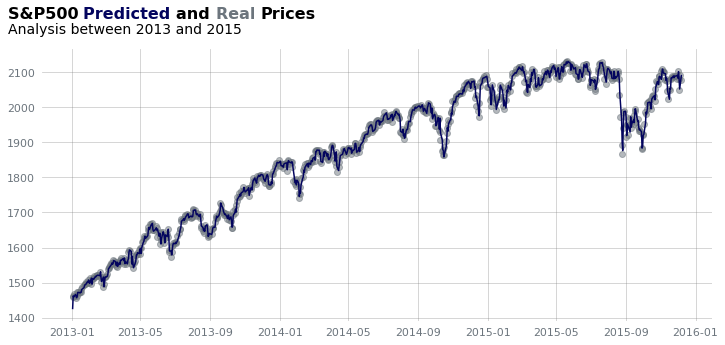

In [32]:
fig, ax = plt.subplots(figsize = (12,5))
ax.scatter(test['Date'], test['Close'], color = '#6C757D', alpha = 0.5)
ax.plot(test['Date'], linear, color = '#03045E', linewidth = 1.5)
ax.tick_params(left = False, bottom = False)
ax.tick_params(axis = 'x', colors = '#6C757D', labelsize = 11)
ax.tick_params(axis = 'y', colors = '#6C757D', labelsize = 11)
ax.grid(color = 'grey', alpha = 0.4)

for location in ['left', 'right','top','bottom']:
  ax.spines[location].set_visible(False)

ax.text(dt.datetime(2012,9,10), 2253, 'S&P500 ', size = 16, weight = 'bold')
ax.text(dt.datetime(2013,1,20), 2253, 'Predicted ', size = 16, weight = 'bold', color = '#03045E')
ax.text(dt.datetime(2013,7,2), 2253, 'and ', size = 16, weight = 'bold')
ax.text(dt.datetime(2013,9,10), 2253, 'Real ', size = 16, weight = 'bold', color = '#6C757D')
ax.text(dt.datetime(2013,11,28), 2253, 'Prices', size = 16, weight = 'bold')
ax.text(dt.datetime(2012,9,10), 2210, 'Analysis between 2013 and 2015', size = 14);

## **Conclusões Gerais** 👓

Pode-se concluir que o modelo linear em questão está lidando com dados que possuem uma variação muito baixa, sendo as previsões a respeito de preços facilmente feitas.

Para exemplificar se o modelo poderia ter alguma dificuldade em prever preços diante de acontecimentos esporádicos, experimentou-se treiná-lo com um conjunto de dados anterior a 2007, para a previsão de preços do índice S&P500 nos anos de 2007 e 2008, lembrados pela [crise da bolha imobiliária](https://brasil.elpais.com/brasil/2017/08/05/economia/1501927439_342599.html).

In [33]:
train = df.loc[df['Date'] <= '2006-12-31', :]
test = df.loc[(df['Date'] >= '2007-01-01') & (df['Date'] <= '2008-12-31'), :]

In [34]:
model_5 = LinearRegression()
model_5.fit(train[['Open','Day_30','Day_365','Ratio_30_365']], train['Close'])
predictions = model_5.predict(test[['Open','Day_30','Day_365','Ratio_30_365']])
mse_5 = mean_squared_error(test['Close'], predictions)
r2_5 = r2_score(test['Close'], predictions)
print(f'mse_5: {mse_5}')
print(f'r2_5: {r2_5}')

mse_5: 432.06805881762307
r2_5: 0.9879473945800061


Apesar do MSE bem maior - o que indica maiores desvios entre os dados reais e aqueles previstos - o modelo ainda se manteve preciso em suas previsões, uma vez que até mesmo para o dia 17 de setembro de 2007, no auge da crise, foram registradas poucas variações de preço para o índice entre a abertura e fechamento do mercado de ações:

In [35]:
test.loc[2071]

Date            2007-09-17 00:00:00
Open                        1484.24
High                        1484.24
Low                         1471.82
Close                       1476.65
Volume                  2.59839e+09
Adj Close                   1476.65
Day_30                      1459.16
Day_365                      1391.5
Ratio_30_365                1.04863
Name: 2071, dtype: object

Pode-se concluir que pelo fato de o modelo levar em consideração os dados disponibilizados para um determinado dia, de forma bastante específica, as previsões acabam sendo bastante próximas da realidade, o que é ainda potencializado pelo uso de uma **equação linear** para obtenção dos valores de previsão.